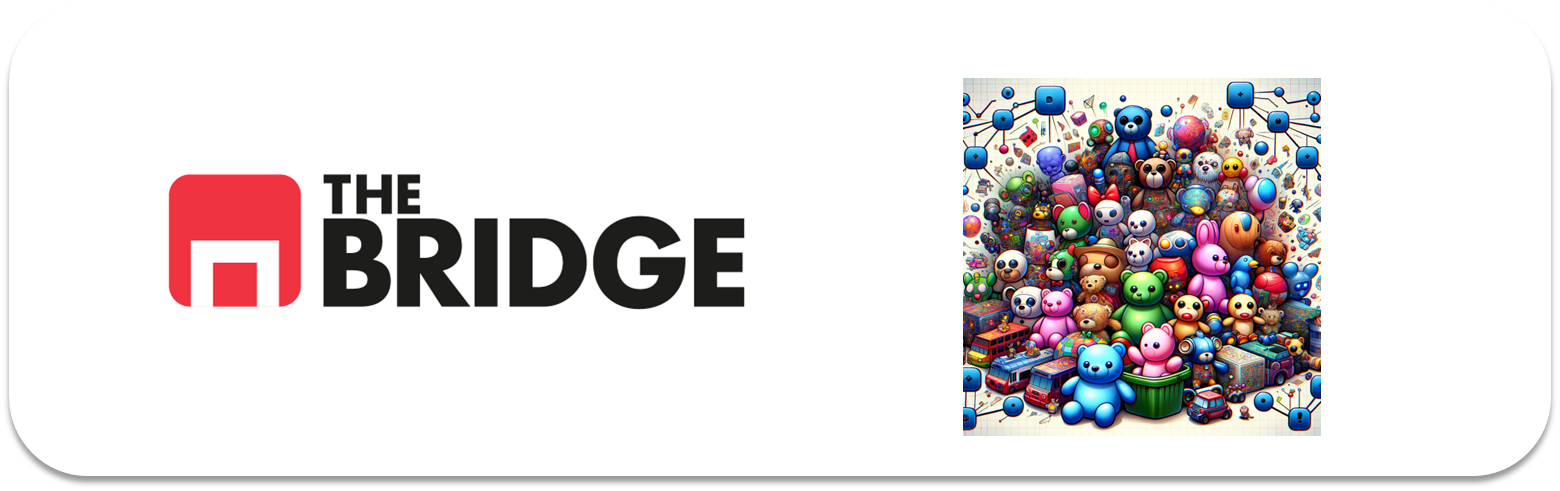

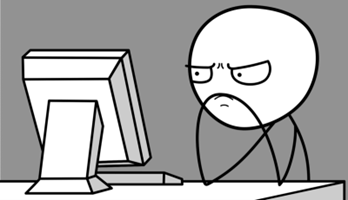

Para ejercitarte y afianzar lo aprendido sobre **K-Means**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [34]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

### Entendiendo el problema de negocio

En este notebook vamos a hacer un análisis de datos tirando de clusterizaciones para evaluar si existen grupos en nuestros productos, en este caso medicamentos, y posteriormente poder etiquetarlos. Poseemos información como rating, efectividad, efectos secundarios, entre otros.

### Ejercicio 1

Importa los datos, "./data/drugLibTrain_raw.tsv", que contiene un dataset con diferentes fármacos, sus efectos y ratings de los clientes de dichos fármacos. Realiza una inspección preliminar y quita las columnas que consideres innecesarias.

In [35]:
df = pd.read_csv('data/drugLibTrain_raw.tsv', sep = '\t')
df.head(5)

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         3107 non-null   int64 
 1   urlDrugName        3107 non-null   object
 2   rating             3107 non-null   int64 
 3   effectiveness      3107 non-null   object
 4   sideEffects        3107 non-null   object
 5   condition          3106 non-null   object
 6   benefitsReview     3089 non-null   object
 7   sideEffectsReview  3032 non-null   object
 8   commentsReview     3095 non-null   object
dtypes: int64(2), object(7)
memory usage: 218.6+ KB


In [37]:
df.drop(columns = 'Unnamed: 0', axis = 1, inplace = True)

### Ejercicio 2: MiniEDA

Como es un problema no supervisado (vamos a intentar agrupar los medicamentos sin tener una referencia o target inicial), no hay split, vamos directos al miniEDA. Analiza qué variables son descartables en función de su porcentaje de cardinalidad. Es decir obten la cardinalidad y su porcentaje para cada posible feature y crea un dataset nuevo descartando las features que creas conveniente. NOTA: Como simplificación, descarta la columna con url.

In [38]:
for col in df.columns:
    cardinalidad = df[col].nunique() / len(df)
    print(f"Cardinalidad de la columna '{col}: {cardinalidad * 100:.2f} %")

Cardinalidad de la columna 'urlDrugName: 16.16 %
Cardinalidad de la columna 'rating: 0.32 %
Cardinalidad de la columna 'effectiveness: 0.16 %
Cardinalidad de la columna 'sideEffects: 0.16 %
Cardinalidad de la columna 'condition: 45.90 %
Cardinalidad de la columna 'benefitsReview: 97.55 %
Cardinalidad de la columna 'sideEffectsReview: 90.54 %
Cardinalidad de la columna 'commentsReview: 98.04 %


Como la cardinalidad de `Unnamed: 0` es del 100% lo pondremos como índice del dataset

In [39]:
features_selected = ['rating','effectiveness','sideEffects']

### Ejercicio 3

Construye un train set (llámalo X) sólo con las features que hayas seleccionado del ejercicio anterior (es decir las que no hayas descartado como posibles features) 

In [40]:
x = df[features_selected]

In [41]:
x.head(5)

,rating,effectiveness,sideEffects
0,4,Highly Effective,Mild Side Effects
1,1,Highly Effective,Severe Side Effects
2,10,Highly Effective,No Side Effects
3,3,Marginally Effective,Mild Side Effects
4,2,Marginally Effective,Severe Side Effects


### Ejercicio 4 

Trasforma las features que consideres necesario (categóricas y numéricas) y luego aplica el escalado que consideres necesario.

In [42]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   rating         3107 non-null   int64 
 1   effectiveness  3107 non-null   object
 2   sideEffects    3107 non-null   object
dtypes: int64(1), object(2)
memory usage: 72.9+ KB


Viendo las features que hemos seleccionado podemos ver que solo hay categóricas.

In [43]:
x.sideEffects.value_counts()

sideEffects
Mild Side Effects                1019
No Side Effects                   930
Moderate Side Effects             614
Severe Side Effects               369
Extremely Severe Side Effects     175
Name: count, dtype: int64

In [44]:
side_effect_map = {'Mild Side Effects': 1, 'Severe Side Effects': 3, 'No Side Effects': 0,
       'Extremely Severe Side Effects': 4, 'Moderate Side Effects': 2}

effectiveness_map = {'Highly Effective': 4, 'Marginally Effective': 1, 'Ineffective': 0,
       'Considerably Effective': 3, 'Moderately Effective': 2}

In [45]:
x['sideEffects'] = x['sideEffects'].map(side_effect_map)
x['effectiveness'] = x['effectiveness'].map(effectiveness_map)

C:\Users\usuar\AppData\Local\Temp\ipykernel_15876\145324387.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['sideEffects'] = x['sideEffects'].map(side_effect_map)
C:\Users\usuar\AppData\Local\Temp\ipykernel_15876\145324387.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['effectiveness'] = x['effectiveness'].map(effectiveness_map)


In [46]:
x.head()

,rating,effectiveness,sideEffects
0,4,4,1
1,1,4,3
2,10,4,0
3,3,1,1
4,2,1,3


Escalado de las variables

In [47]:
minmax = MinMaxScaler()
x[:] = minmax.fit_transform(x)
x.head()

C:\Users\usuar\AppData\Local\Temp\ipykernel_15876\4017240476.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[:] = minmax.fit_transform(x)
C:\Users\usuar\AppData\Local\Temp\ipykernel_15876\4017240476.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.33333333 0.         1.         ... 0.11111111 0.77777778 0.33333333]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  x[:] = minmax.fit_transform(x)
C:\Users\usuar\AppData\Local\Temp\ipykernel_15876\4017240476.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.   1.   1.   ... 0.25 0.75 0.5 ]' has dtype in

,rating,effectiveness,sideEffects
0,0.333333,1.00,0.25
1,0.000000,1.00,0.75
2,1.000000,1.00,0.00
3,0.222222,0.25,0.25
4,0.111111,0.25,0.75


### Ejercicio 5: Obtención de K, aproximación visual

Analiza la relación entre features (con scatter plots) una vez transformadas para comprobar si existe visualmente algún indicio del número de clústeres que podríamos estar buscando. Por otro lado este análisis nos puede hacer descartar alguna feature o generar una nueva

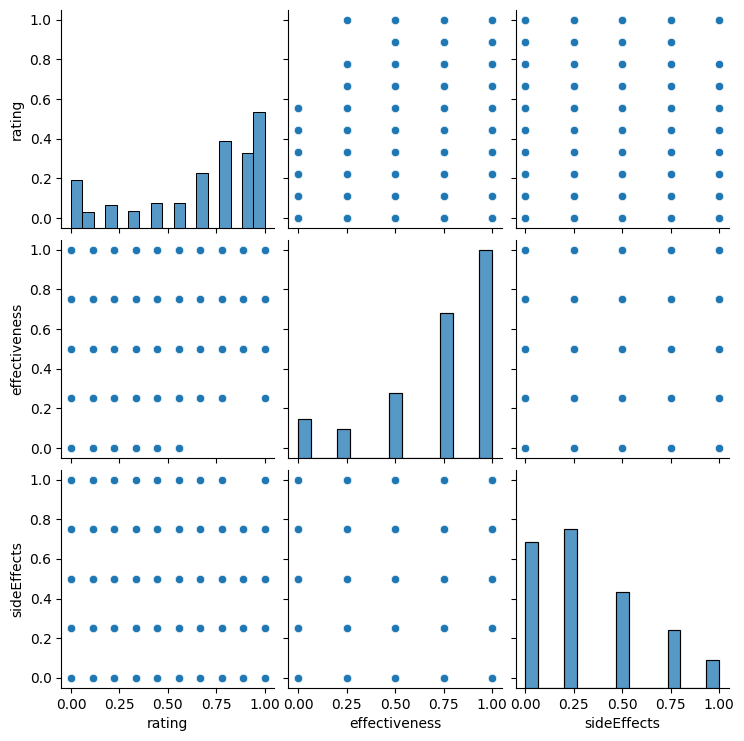

In [48]:
sns.pairplot(data = x);

Podemos observar en el gráfico de arriba que hay una mayor cantidad de medicamentos con efectos posivitos que con efecto negativos. También observamos que hay mayor cantidad de medicamentos como poco efectos secundarios.

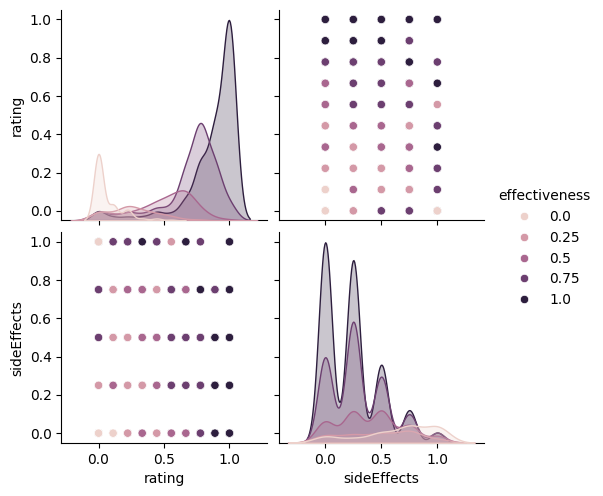

In [49]:
sns.pairplot(x, hue = 'effectiveness');

Se puede observar una clusterización ya que los colores tienden a oscurecerse a medida que tanto en rating como sideEffects aumentan

### Ejercicio 6: Obtención de K, método del codo

Evalua diferentes valores K y escoge uno a partir del método del codo/elbow de inercia.

In [50]:
ks = []
inertias = []

for k in range(1,10):
    clustering = KMeans(n_clusters = k)
    clustering.fit(x)
    inertias.append(clustering.inertia_)
    ks.append(k)

In [51]:
df_inertias = pd.DataFrame({'k':ks, 'Inercias': inertias})
df_inertias

,k,Inercias
0,1,893.992575
1,2,395.535172
2,3,302.210780
3,4,252.971662
4,5,195.089385
5,6,159.203263
6,7,140.158887
7,8,118.732526
8,9,108.162315


In [52]:
df_inertias['diff'] = df_inertias['Inercias'] - df_inertias['Inercias'].shift(1)
df_inertias

,k,Inercias,diff
0,1,893.992575,NaN
1,2,395.535172,-498.457403
2,3,302.210780,-93.324392
3,4,252.971662,-49.239117
4,5,195.089385,-57.882277
5,6,159.203263,-35.886122
6,7,140.158887,-19.044376
7,8,118.732526,-21.426361
8,9,108.162315,-10.570211


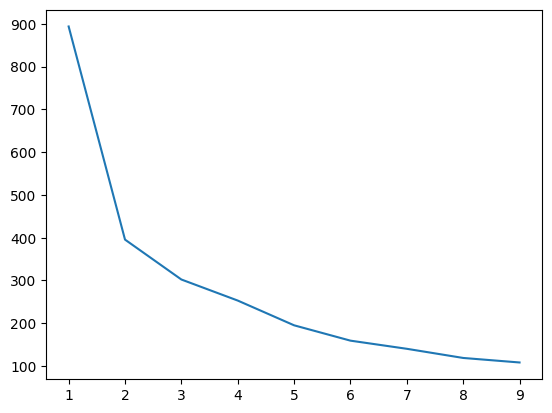

In [53]:
plt.plot(ks, inertias);

Encontrarmos un codo en $k = 2$. Una mayor cantidad de k no ayudaría mucho al modelo y menor cantidad de k sería peor. Por lo que $k = 2$ es el número de cluster óptimo. Veamos más de cerca estos clusters para ver si el codo está realmente en $k = 2$.

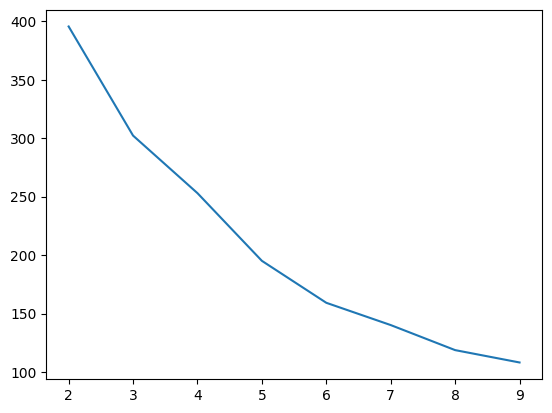

In [54]:
plt.plot(ks[1::], inertias[1::]);

### Ejercicio 7: Obtención de K, Score de Silueta

Comprueba el ajuste de k obteniendo el k que maximiza el score de silueta y pinta un gráfico de la evolución de dicho score con k. Usa los valores de k que hayas probado en el ejercicio anterior.

In [55]:
ks = []
sil_scores = []

for k in range(2, 10): 
    clustering = KMeans(n_clusters = k)
    clustering.fit(x)

    sil_scores.append(silhouette_score(x, clustering.labels_))
    ks.append(k)

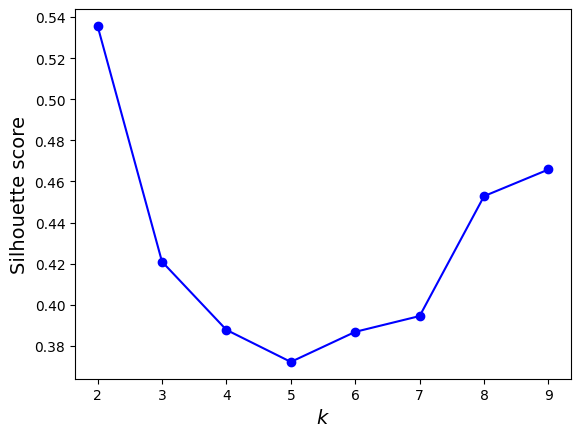

In [56]:
plt.plot(ks, sil_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

El k con el `silhouette score` más alto es $k = 2$

### Ejercicio 8: Obtención de K, diagrama de silueta

Para completar el estudio de k, muestra el diagrama de silueta para k=2,3,4,5 y decide con este datos y los anteriores el valor de k a probar. NOTA: En la realidad, podríamos probar perfectamente k=2 y k=3 y luego que "Negocio" decidiera cuál le es más útil, aquí lo completamos por practicar todo lo aprendido

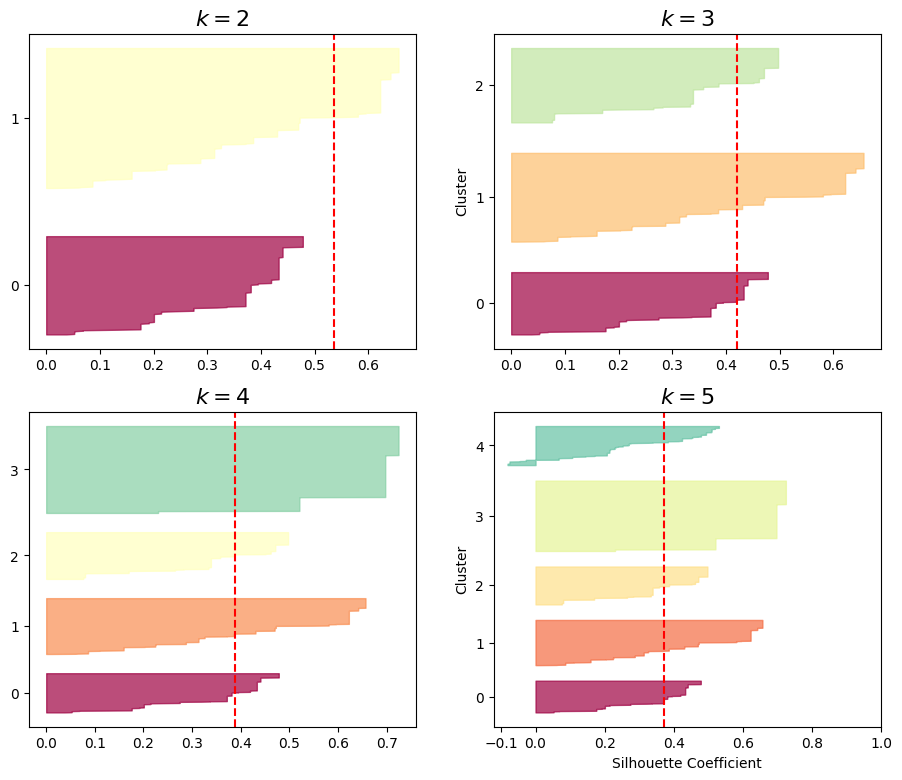

In [57]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

'''
La anchura de cada cuchillo representa el numero de muestras por cluster. Están ordenadas
por su coeficiente de silhouette, por eso tiene esa forma de cuchillo. Cuanta más caida tenga
indica que las muestras tienen un coeficiente mas disperso en ese cluster
Deberian estar todos los clusters por encima de la media.
Hay algunas lineas hacia la izda xq es el coeficiente negativo. Puntos asignados al cluster erroneo.
'''
plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    
    y_pred = clustering.labels_
    silhouette_coefficients = silhouette_samples(x, y_pred)

    padding = len(x) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=True)

    plt.axvline(x=sil_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

En términos de cruzar el silhouette score, todos los k escogidos lo superan aunque algunos con dificultades (5). El que mejor resultados nos da es el 2, ya que ambos clusters sobrepasan el 0.6, mientras que k = 3 y k = 4 alguna de sus clases está por debajo del 0.6

### Ejercico 9:

En general, una diferencia entre el proceso de construcción de un modelo no supervisado y un supervisado es que el ajuste de algunos hiperparámetros (como el número de clústeres) es anterior a la construcción del modelo. Por eso, construye un K-means para el valor (o valores) de K escogidos.

In [58]:
clustering_k2 = KMeans(n_clusters = 2)
clustering_k2.fit(x)

KMeans(n_clusters=2)

### Ejercicio 10

Vamos a comprobar resultados, analizando los valores medios y distribución de cada uno de los clústeres para el k óptimo. Si tuvieras más de un posible valor de k a probar, analiza aquí el de mayor score de silueta. Y utiliza el siguiente ejercicio para el otro. Además de hacer un describe de las features por clúster, pinta estos con un pairplot considerando sideEffects y rating como x e y (o viceversa) y el clúster como hue (color). Compara el resultado con los clústeres sugeridos en el ejercicio 5.

In [59]:
x['cluster'] = clustering_k2.predict(x)
x.head()

C:\Users\usuar\AppData\Local\Temp\ipykernel_15876\390573012.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['cluster'] = clustering_k2.predict(x)


,rating,effectiveness,sideEffects,cluster
0,0.333333,1.00,0.25,0
1,0.000000,1.00,0.75,1
2,1.000000,1.00,0.00,0
3,0.222222,0.25,0.25,1
4,0.111111,0.25,0.75,1


In [60]:
x.cluster.value_counts(normalize=True)

cluster
0    0.73093
1    0.26907
Name: proportion, dtype: float64

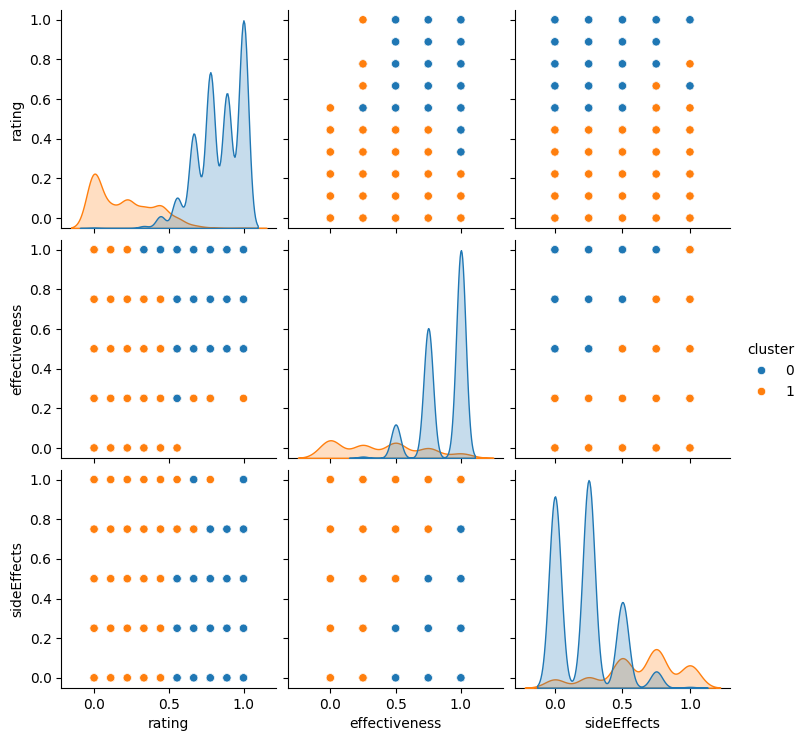

In [62]:
sns.pairplot(data = x, hue = 'cluster');

### Ejercicio 11, EXTRA: Más valores de K

Repite el análisis del ejercicio 10 para un K diferente pero que consideres que tiene sentido aplicar.